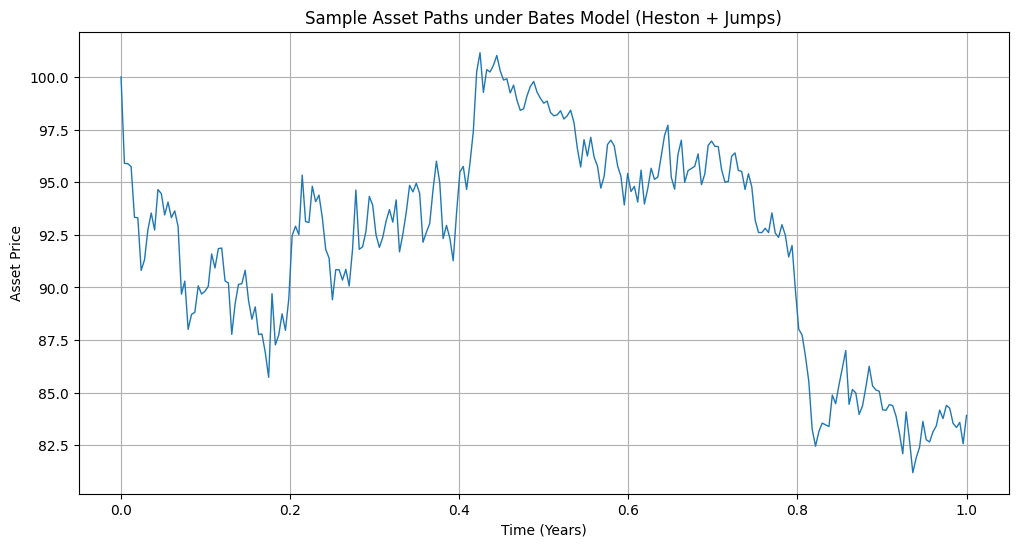

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100.0         # Initial asset price
v0 = 0.25**2       # Initial variance
r = 0.02           # Risk-free rate
kappa = 3.0        # Rate of mean reversion
theta = 0.20**2    # Long-run variance
xi = 0.5           # Vol of vol
rho = -0.7        # Correlation

T = 1.0            # Time horizon
N = 252            # Time steps
M = 100000         # Number of paths

lambd = 0.2      # Jump intensity (jumps per year)
mu_j = 0.1       # Mean jump size (in log)
sigma_j = 0.2    # Volatility of jump size

dt = T / N

S_bates = np.full(shape=(N + 1, M), fill_value=S0)
v_bates = np.full(shape=(N + 1, M), fill_value=v0)

mu = np.array([0, 0])
cov = np.array([[1, rho], 
                [rho, 1]])

Z = np.random.multivariate_normal(mu, cov, (N, M))

for n in range(N):
    v_bates[n + 1] = np.maximum(v_bates[n] + kappa * (theta - v_bates[n]) * dt + xi * np.sqrt(v_bates[n] * dt) * Z[n, :, 1], 0) # Add truncation

    jumps = np.random.poisson(lambd * dt, M)
    jump_sizes = (np.exp(mu_j + sigma_j * np.random.normal(size=M)) - 1) * jumps

    drift = (r - 0.5 * v_bates[n] - lambd * (np.exp(mu_j + 0.5 * sigma_j**2) - 1)) * dt
    diffusion = np.sqrt(v_bates[n]) * np.sqrt(dt) * Z[n, :, 0]
    S_bates[n+1] = S_bates[n] * np.exp(drift + diffusion) * (1 + jump_sizes)

plt.figure(figsize=(12,6))
for i in range(1):
    plt.plot(np.linspace(0, T, N+1), S_bates[:, i], lw=1)
plt.title('Sample Asset Paths under Bates Model (Heston + Jumps)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

In [2]:
def heston_model(S0, v0, rho, kappa, theta, xi, T, N, M):

    dt = T / N

    S = np.full(shape=(N + 1, M), fill_value=S0)
    v = np.full(shape=(N + 1, M), fill_value=v0)

    mu = np.array([0, 0])
    cov = np.array([[1, rho], 
                    [rho, 1]])

    Z = np.random.multivariate_normal(mu, cov, (N, M))

    for n in range(N):
        S[n + 1] = S[n] + r * S[n] * dt + np.sqrt(v[n] * dt) * S[n] * Z[n, :, 0]
        v[n + 1] = np.maximum(v[n] + kappa * (theta - v[n]) * dt + xi * np.sqrt(v[n] * dt) * Z[n, :, 1], 0) # Add truncation

    return S, v

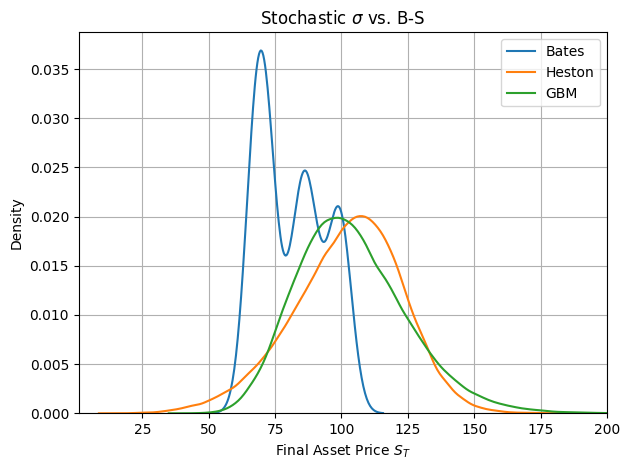

In [3]:
import seaborn as sns

S_heston, v_heston = heston_model(S0, v0, rho, kappa, theta, xi, T, N, M)

S_gbm = S0 * np.exp((r - 0.5 * theta ** 2) * T + np.sqrt(theta * T) * np.random.randn(M))

sns.kdeplot(data=S_bates[:, -1], label=rf"Bates")
sns.kdeplot(data=S_heston[-1], label=rf"Heston")
sns.kdeplot(data=S_gbm, label="GBM")

plt.xlabel('Final Asset Price $S_T$')
plt.ylabel('Density')
plt.xlim(1, 200)
plt.title(rf"Stochastic $\sigma$ vs. B-S")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()